# Comparison with Seapodym-LMTL Zooplankton


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from IPython.display import Markdown

from seapopym.configuration.no_transport.configuration import NoTransportConfiguration
from seapopym.configuration.no_transport.parameter import ForcingParameters, FunctionalGroups, NoTransportParameters
from seapopym.configuration.parameters.parameter_environment import (
    EnvironmentParameter,
    OutputParameter,
    PreProductionParameter,
)
from seapopym.configuration.parameters.parameter_forcing import ForcingUnit
from seapopym.configuration.parameters.parameter_functional_group import (
    FunctionalGroupUnit,
    FunctionalGroupUnitMigratoryParameters,
    FunctionalGroupUnitRelationParameters,
)
from seapopym.logging.custom_logger import set_verbose
from seapopym.model.no_transport_model import NoTransportModel
from seapopym.standard.units import StandardUnitsLabels

set_verbose()

In [2]:
path_forcing = (
    "/Users/ash/Documents/Workspaces/Data/phd/cmems_mod_glo_bgc_my_0.083deg-lmtl-Fphy_PT1D-i_1709010880580.nc"
)
path_bio = "/Users/ash/Documents/Workspaces/Data/phd/cmems_mod_glo_bgc_my_0.083deg-lmtl_PT1D-i_1709007157635.nc"

forcing = xr.open_dataset(path_forcing)
forcing["T"].attrs["units"] = StandardUnitsLabels.temperature.units
display(Markdown("### Physics"))
display(forcing)
bio = xr.open_dataset(path_bio)
display(Markdown("### Biology"))
display(bio)

### Physics

<xarray.Dataset> Size: 131MB
Dimensions:              (time: 4748, depth: 3, latitude: 24, longitude: 24)
Coordinates:
  * depth                (depth) float32 12B 1.0 2.0 3.0
  * latitude             (latitude) float32 96B 22.08 22.17 22.25 ... 23.92 24.0
  * longitude            (longitude) float32 96B -159.0 -158.9 ... -157.2 -157.1
  * time                 (time) datetime64[ns] 38kB 2010-01-01 ... 2022-12-31
Data variables:
    T                    (time, depth, latitude, longitude) float32 33MB ...
    U                    (time, depth, latitude, longitude) float32 33MB ...
    V                    (time, depth, latitude, longitude) float32 33MB ...
    pelagic_layer_depth  (time, depth, latitude, longitude) float32 33MB ...
Attributes:
    Conventions:       CF-1.11
    title:             Physical forcings of global ocean low and mid trophic ...
    institution:       CLS
    source:            SEAPODYM-LMTL 3.0.0
    history:           Created on 2022-09-28
    references:        http://www.cls.fr; http://www.seapodym.eu
    subset:source:     ARCO data downloaded from the Marine Data Store using ...
    subset:productId:  GLOBAL_MULTIYEAR_BGC_001_033
    subset:datasetId:  cmems_mod_glo_bgc_my_0.083deg-lmtl-Fphy_PT1D-i_202211
    subset:date:       2024-02-27T05:14:40.588Z

### Biology

<xarray.Dataset> Size: 98MB
Dimensions:       (latitude: 24, longitude: 24, time: 4748)
Coordinates:
  * latitude      (latitude) float32 96B 22.08 22.17 22.25 ... 23.83 23.92 24.0
  * longitude     (longitude) float32 96B -159.0 -158.9 -158.8 ... -157.2 -157.1
  * time          (time) datetime64[ns] 38kB 2010-01-01 ... 2022-12-31
Data variables:
    mnkc_epi      (time, latitude, longitude) float32 11MB ...
    mnkc_hmlmeso  (time, latitude, longitude) float32 11MB ...
    mnkc_lmeso    (time, latitude, longitude) float32 11MB ...
    mnkc_mlmeso   (time, latitude, longitude) float32 11MB ...
    mnkc_mumeso   (time, latitude, longitude) float32 11MB ...
    mnkc_umeso    (time, latitude, longitude) float32 11MB ...
    npp           (time, latitude, longitude) float32 11MB ...
    zeu           (time, latitude, longitude) float32 11MB ...
    zooc          (time, latitude, longitude) float32 11MB ...
Attributes:
    Conventions:       CF-1.11
    title:             Global ocean low and mid trophic levels biomass conten...
    institution:       CLS
    source:            SEAPODYM-LMTL 3.0.0
    history:           Created on 2022-09-28
    references:        http://www.cls.fr; http://www.seapodym.eu
    subset:source:     ARCO data downloaded from the Marine Data Store using ...
    subset:productId:  GLOBAL_MULTIYEAR_BGC_001_033
    subset:datasetId:  cmems_mod_glo_bgc_my_0.083deg-lmtl_PT1D-i_202211
    subset:date:       2024-02-27T04:12:37.642Z

## Initialize the model


In [3]:
day_layer = 1
night_layer = 1
tr_max = 10.38
tr_rate = -0.11
inv_lambda_max = 150
inv_lambda_rate = 0.15

f_groups = FunctionalGroups(
    functional_groups=[
        FunctionalGroupUnit(
            name=f"D{day_layer}N{night_layer}",
            migratory_type=FunctionalGroupUnitMigratoryParameters(day_layer=1, night_layer=night_layer),
            functional_type=FunctionalGroupUnitRelationParameters(
                inv_lambda_max=inv_lambda_max,
                inv_lambda_rate=inv_lambda_rate,
                temperature_recruitment_rate=tr_rate,
                cohorts_timesteps=[1] * np.ceil(tr_max).astype(int),
                temperature_recruitment_max=tr_max,
            ),
            energy_transfert=0.1668,
        )
    ]
)

p_param = ForcingParameters(
    temperature=ForcingUnit(forcing=forcing["T"], resolution=0.08333),
    primary_production=ForcingUnit(forcing=bio["npp"], resolution=0.08333),
    initial_condition_biomass=None,
    initial_condition_production=None,
)

parameters = NoTransportParameters(
    functional_groups_parameters=f_groups,
    forcing_parameters=p_param,
    environment_parameters=EnvironmentParameter(
        output=OutputParameter(pre_production=PreProductionParameter(timestamps="all"))
    ),
)
zooplankton_model = NoTransportModel(configuration=NoTransportConfiguration(parameters))
zooplankton_model.state

2024-04-09 15:11:56,402 :: Seapodym ::  WARNING ::
|	npp unit is milligram / day / meter ** 2, it will be converted to kilogram / day / meter ** 2.



<xarray.Dataset> Size: 44MB
Dimensions:                       (functional_group: 1, depth: 3, latitude: 24,
                                   longitude: 24, time: 4748, cohort: 11)
Coordinates:
  * functional_group              (functional_group) int64 8B 0
  * depth                         (depth) float32 12B 1.0 2.0 3.0
  * latitude                      (latitude) float32 96B 22.08 22.17 ... 24.0
  * longitude                     (longitude) float32 96B -159.0 ... -157.1
  * time                          (time) datetime64[ns] 38kB 2010-01-01 ... 2...
  * cohort                        (cohort) int64 88B 0 1 2 3 4 5 6 7 8 9 10
Data variables: (12/17)
    name                          (functional_group) <U4 16B 'D1N1'
    energy_transfert              (functional_group) float64 8B 0.1668
    inv_lambda_max                (functional_group) float64 8B 150.0
    inv_lambda_rate               (functional_group) float64 8B 0.15
    temperature_recruitment_max   (functional_group) float64 8B 10.38
    temperature_recruitment_rate  (functional_group) float64 8B -0.11
    ...                            ...
    resolution_latitude           float64 8B 0.08333
    resolution_longitude          float64 8B 0.08333
    timesteps_number              (functional_group, cohort) int64 88B 1 1 ... 1
    min_timestep                  (functional_group, cohort) int64 88B 1 ... 11
    max_timestep                  (functional_group, cohort) int64 88B 1 ... 11
    mean_timestep                 (functional_group, cohort) float64 88B 1.0 ...

## Run the model


In [4]:
zooplankton_model.run()
zooplankton_model.state

2024-04-09 15:11:56,898 :: Seapodym ::  INFO ::
|	Computing production for Cohort 0



<xarray.Dataset> Size: 665MB
Dimensions:                       (functional_group: 1, depth: 3, latitude: 24,
                                   longitude: 24, time: 4748, cohort: 11)
Coordinates:
  * functional_group              (functional_group) int64 8B 0
  * depth                         (depth) float32 12B 1.0 2.0 3.0
  * latitude                      (latitude) float32 96B 22.08 22.17 ... 24.0
  * longitude                     (longitude) float32 96B -159.0 ... -157.1
  * time                          (time) datetime64[ns] 38kB 2010-01-01 ... 2...
  * cohort                        (cohort) int64 88B 0 1 2 3 4 5 6 7 8 9 10
Data variables: (12/29)
    name                          (functional_group) <U4 16B 'D1N1'
    energy_transfert              (functional_group) float64 8B 0.1668
    inv_lambda_max                (functional_group) float64 8B 150.0
    inv_lambda_rate               (functional_group) float64 8B 0.15
    temperature_recruitment_max   (functional_group) float64 8B 10.38
    temperature_recruitment_rate  (functional_group) float64 8B -0.11
    ...                            ...
    mask_temperature              (functional_group, time, latitude, longitude, cohort) bool 30MB ...
    cell_area                     (latitude, longitude) float64 5kB 7.956e+07...
    mortality_field               (functional_group, time, latitude, longitude) float64 22MB ...
    recruited                     (functional_group, time, latitude, longitude, cohort) float64 241MB ...
    preproduction                 (functional_group, time, latitude, longitude, cohort) float64 241MB ...
    biomass                       (functional_group, time, latitude, longitude) float64 22MB ...

## Plotting the results


In [5]:
biomass_seapopym = zooplankton_model.state.biomass.load()
biomass_lmtl = bio.zooc.pint.quantify().pint.to(StandardUnitsLabels.biomass.units).pint.dequantify()

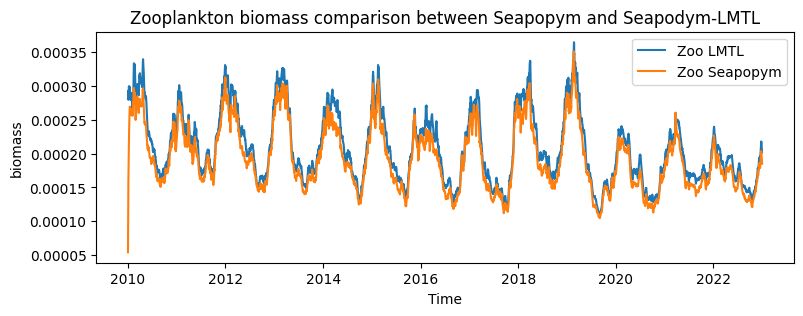

In [6]:
plt.figure(figsize=(9, 3))
(biomass_lmtl.cf.mean(("X", "Y"))).cf.plot.line(x="T", label="Zoo LMTL")
(biomass_seapopym.cf.mean(("X", "Y"))).cf.plot.line(x="T", hue="functional_group", label="Zoo Seapopym")
plt.legend()
plt.title("Zooplankton biomass comparison between Seapopym and Seapodym-LMTL")
plt.show()

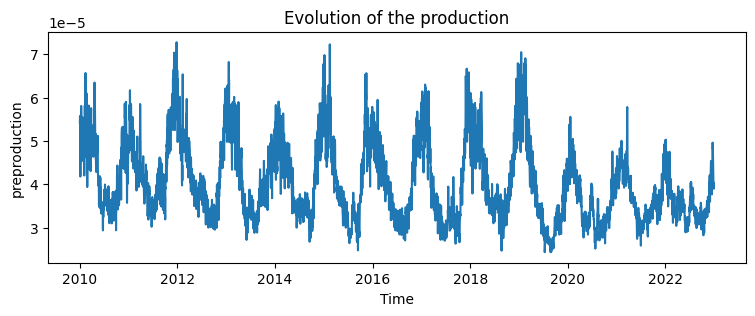

In [7]:
plt.figure(figsize=(9, 3))
zooplankton_model.state.preproduction[0].cf.mean(("X", "Y")).cf.sum("cohort").cf.plot.line(x="T")
plt.title("Evolution of the production")
plt.show()

---

## Try again with initial conditions


In [8]:
initial_conditions = zooplankton_model.export_initial_conditions()
p_param = ForcingParameters(
    temperature=ForcingUnit(forcing=forcing["T"], resolution=0.08333),
    primary_production=ForcingUnit(forcing=bio["npp"], resolution=0.08333),
    initial_condition_biomass=ForcingUnit(forcing=initial_conditions["initial_condition_biomass"], resolution=0.08333),
    initial_condition_production=ForcingUnit(
        forcing=initial_conditions["initial_condition_production"], resolution=0.08333
    ),
)

parameters = NoTransportParameters(
    functional_groups_parameters=f_groups,
    forcing_parameters=p_param,
    environment_parameters=EnvironmentParameter(
        output=OutputParameter(pre_production=PreProductionParameter(timestamps="all"))
    ),
)
zooplankton_model_with_initial_condition = NoTransportModel(configuration=NoTransportConfiguration(parameters))
zooplankton_model_with_initial_condition.state

2024-04-09 15:12:02,014 :: Seapodym ::  WARNING ::
|	npp unit is milligram / day / meter ** 2, it will be converted to kilogram / day / meter ** 2.



<xarray.Dataset> Size: 44MB
Dimensions:                       (functional_group: 1, depth: 3, latitude: 24,
                                   longitude: 24, time: 4748, cohort: 11)
Coordinates:
  * functional_group              (functional_group) int64 8B 0
  * depth                         (depth) float32 12B 1.0 2.0 3.0
  * latitude                      (latitude) float32 96B 22.08 22.17 ... 24.0
  * longitude                     (longitude) float32 96B -159.0 ... -157.1
  * time                          (time) datetime64[ns] 38kB 2010-01-01 ... 2...
  * cohort                        (cohort) int64 88B 0 1 2 3 4 5 6 7 8 9 10
Data variables: (12/19)
    name                          (functional_group) <U4 16B 'D1N1'
    energy_transfert              (functional_group) float64 8B 0.1668
    inv_lambda_max                (functional_group) float64 8B 150.0
    inv_lambda_rate               (functional_group) float64 8B 0.15
    temperature_recruitment_max   (functional_group) float64 8B 10.38
    temperature_recruitment_rate  (functional_group) float64 8B -0.11
    ...                            ...
    resolution_latitude           float64 8B 0.08333
    resolution_longitude          float64 8B 0.08333
    timesteps_number              (functional_group, cohort) int64 88B 1 1 ... 1
    min_timestep                  (functional_group, cohort) int64 88B 1 ... 11
    max_timestep                  (functional_group, cohort) int64 88B 1 ... 11
    mean_timestep                 (functional_group, cohort) float64 88B 1.0 ...

## Run the model


In [9]:
zooplankton_model_with_initial_condition.run()
zooplankton_model_with_initial_condition.state

2024-04-09 15:12:02,577 :: Seapodym ::  INFO ::
|	Computing production for Cohort 0



<xarray.Dataset> Size: 665MB
Dimensions:                       (functional_group: 1, depth: 3, latitude: 24,
                                   longitude: 24, time: 4748, cohort: 11)
Coordinates:
  * functional_group              (functional_group) int64 8B 0
  * depth                         (depth) float32 12B 1.0 2.0 3.0
  * latitude                      (latitude) float32 96B 22.08 22.17 ... 24.0
  * longitude                     (longitude) float32 96B -159.0 ... -157.1
  * time                          (time) datetime64[ns] 38kB 2010-01-01 ... 2...
  * cohort                        (cohort) int64 88B 0 1 2 3 4 5 6 7 8 9 10
Data variables: (12/31)
    name                          (functional_group) <U4 16B 'D1N1'
    energy_transfert              (functional_group) float64 8B 0.1668
    inv_lambda_max                (functional_group) float64 8B 150.0
    inv_lambda_rate               (functional_group) float64 8B 0.15
    temperature_recruitment_max   (functional_group) float64 8B 10.38
    temperature_recruitment_rate  (functional_group) float64 8B -0.11
    ...                            ...
    mask_temperature              (functional_group, time, latitude, longitude, cohort) bool 30MB ...
    cell_area                     (latitude, longitude) float64 5kB 7.956e+07...
    mortality_field               (functional_group, time, latitude, longitude) float64 22MB ...
    recruited                     (functional_group, time, latitude, longitude, cohort) float64 241MB ...
    preproduction                 (functional_group, time, latitude, longitude, cohort) float64 241MB ...
    biomass                       (functional_group, time, latitude, longitude) float64 22MB ...

## Plotting the results


In [10]:
biomass_seapopym = zooplankton_model_with_initial_condition.state.biomass.load()
biomass_lmtl = bio.zooc.pint.quantify().pint.to(StandardUnitsLabels.biomass.units).pint.dequantify()

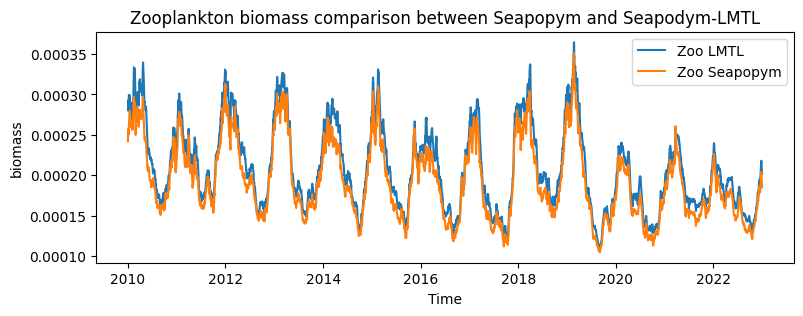

In [11]:
plt.figure(figsize=(9, 3))
(biomass_lmtl.cf.mean(("X", "Y"))).cf.plot.line(x="T", label="Zoo LMTL")
(biomass_seapopym.cf.mean(("X", "Y"))).cf.plot.line(x="T", hue="functional_group", label="Zoo Seapopym")
plt.legend()
plt.title("Zooplankton biomass comparison between Seapopym and Seapodym-LMTL")
plt.show()

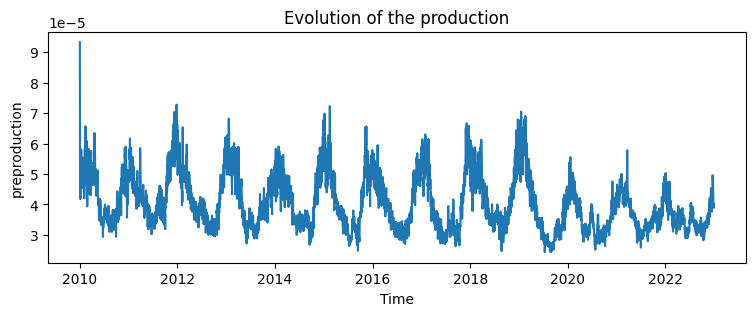

In [12]:
plt.figure(figsize=(9, 3))
zooplankton_model_with_initial_condition.state.preproduction[0].cf.mean(("X", "Y")).cf.sum("cohort").cf.plot.line(x="T")
plt.title("Evolution of the production")
plt.show()